This notebook is developed using the `Python 3 (Data Science)` kernel on an `ml.t3.medium` instance.

In [2]:
!pip install -q sagemaker-experiments

Keyring is skipped due to an exception: 'keyring.backends'

[notice] A new release of pip available: 22.3.1 -> 23.0
[notice] To update, run: pip install --upgrade pip


In [4]:
import sagemaker
import boto3

role = sagemaker.get_execution_role()
sess = sagemaker.Session()
region = sess.boto_region_name
bucket = 'sagemaker-studio-075912829265-fl4eu3b4xp5'
prefix = 'sagemaker-studio-book/chapter06'

print(role)
print(region)
print(bucket)

arn:aws:iam::075912829265:role/service-role/AmazonSageMaker-ExecutionRole-20230127T081684
us-east-1
sagemaker-studio-075912829265-fl4eu3b4xp5


In [24]:
sagemaker.__version__

'2.120.0'

In [25]:
from datetime import datetime, timedelta, timezone
import json, os, re, uuid
from time import sleep, gmtime, strftime

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

from smexperiments.experiment import Experiment
from smexperiments.trial import Trial
from botocore.exceptions import ClientError

from sagemaker import image_uris
from sagemaker.s3 import S3Uploader, S3Downloader
from sagemaker.inputs import TrainingInput

from sagemaker import clarify

In [6]:
orig_columns=['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 
              'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 
              'hours-per-week', 'native-country', 'target']

df=pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data', 
               names=orig_columns, sep=r'\s*,\s*', na_values='?', engine='python')
df_valtest=pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test', 
               names=orig_columns, skiprows=1, sep=r'\s*,\s*', na_values='?', engine='python')

df.drop(columns='education', inplace=True)
df_valtest.drop(columns='education', inplace=True)
df_valtest['target'] = df_valtest['target'].replace(to_replace=['<=50K.', '>50K.'], 
                                                    value=['<=50K', '>50K'])

# move the target column to first for XGBoost
new_columns=df.columns.tolist()
new_columns=[new_columns[-1]]+new_columns[:-1]
df=df[new_columns]
df_valtest=df_valtest[new_columns]

In [7]:
df.head()

,target,age,workclass,fnlwgt,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,<=50K,39,State-gov,77516,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States
1,<=50K,50,Self-emp-not-inc,83311,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States
2,<=50K,38,Private,215646,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States
3,<=50K,53,Private,234721,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States
4,<=50K,28,Private,338409,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba


In [8]:
from sklearn import preprocessing

categorical_columns=df.select_dtypes(include='object').columns

encoder=preprocessing.OrdinalEncoder(dtype=int)
df[categorical_columns]=encoder.fit_transform(df[categorical_columns].fillna('NaN'))
df_valtest[categorical_columns]=encoder.transform(df_valtest[categorical_columns].fillna('NaN'))

After the ordinal encoding, the main features of interest are converted as below.
- sex: Male (1), Female (0)
- target: >50K (1), <=50K (0)

You can see the full mapping in `encoder.categories_`.

In [9]:
from sklearn.model_selection import train_test_split
df_val, df_test = train_test_split(df_valtest, test_size=0.9, random_state=42, 
                                   shuffle=True, stratify=df_valtest['target'])

In [10]:
df.shape, df_valtest.shape, df_val.shape, df_test.shape

((32561, 14), (16281, 14), (1628, 14), (14653, 14))

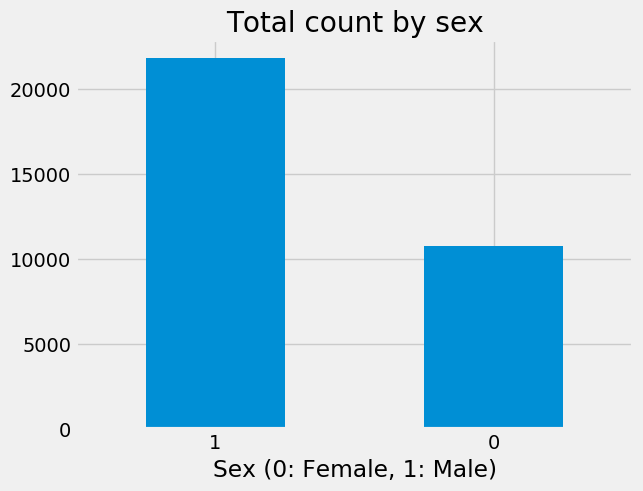

In [12]:
df['sex'].value_counts(sort=False).plot(kind='bar', title='Total count by sex', rot=0)
plt.xlabel('Sex (0: Female, 1: Male)')
plt.show()

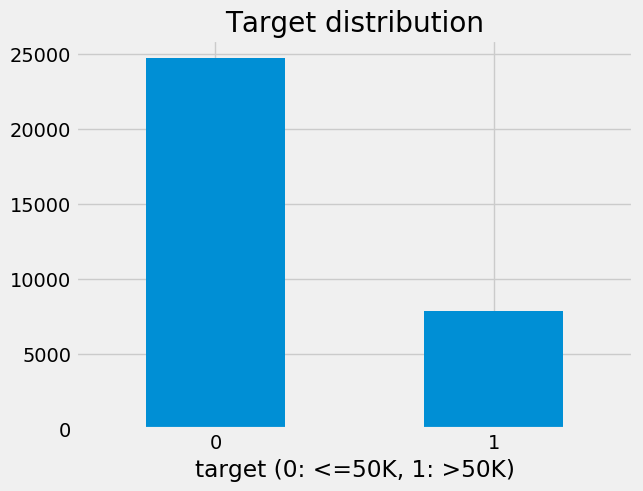

In [13]:
df['target'].value_counts(sort=False).plot(kind='bar', title='Target distribution', rot=0)
plt.xlabel('target (0: <=50K, 1: >50K)')
plt.show()

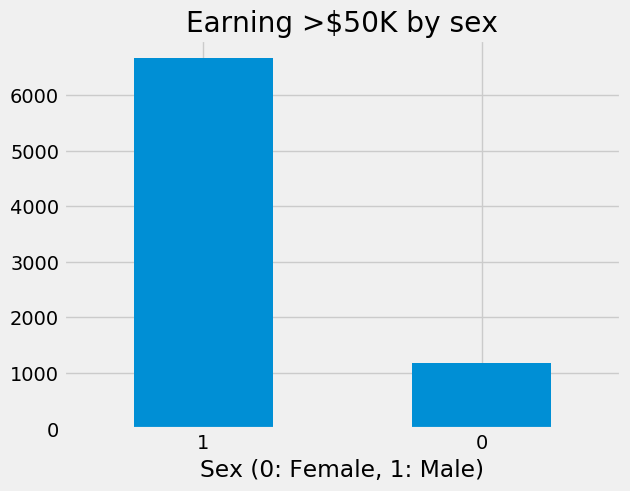

In [14]:
df[df['target']==1]['sex'].value_counts(sort=False).plot(
            kind='bar', title='Earning >$50K by sex', rot=0)
plt.xlabel('Sex (0: Female, 1: Male)')
plt.show()

In [15]:
os.makedirs('adult', exist_ok=True)
df.to_csv('adult/adult-data-train.csv', index=False, header=False)
df_val.to_csv('adult/adult-data-val.csv', index=False, header=False)

train_s3_uri = S3Uploader.upload('adult/adult-data-train.csv', 
                              f's3://{bucket}/{prefix}/adult-data')
val_s3_uri = S3Uploader.upload('adult/adult-data-val.csv', 
                            f's3://{bucket}/{prefix}/adult-data')

In [16]:
from sagemaker import clarify

clarify_processor = clarify.SageMakerClarifyProcessor(
                                    role=role, 
                                    instance_count=1, 
                                    instance_type='ml.m5.xlarge', 
                                    sagemaker_session=sess)

INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: 1.0.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.


In [26]:
# clean up previous experiments

from smexperiments.experiment import Experiment
from smexperiments import experiment

In [37]:
# clean up previous experiments

# from sagemaker.experiments.experiment import _Experiment
# exp = Experiment.load(experiment_name='abalone-age-prediction', sagemaker_session=sess)
# exp._delete_all(action="--force")

exp = Experiment.load(experiment_name='sagemaker-scikit-learn-2023-02-06-08-39-53-088-aws-processing-job')
exp.delete_all(action="--force")

ResourceNotFound: An error occurred (ResourceNotFound) when calling the DescribeExperiment operation: Experiment 'arn:aws:sagemaker:us-east-1:075912829265:experiment/sagemaker-scikit-learn-2023-02-06-08-39-53-088-aws-processing-job' does not exist.

In [36]:
# clean up previous experiments

for exp in experiment.Experiment.list():

    exp = Experiment.load(experiment_name = exp.experiment_name)
    exp.delete_all(action="--force")

In [38]:
experiment_name = 'adult-income-clarify'

try:
    experiment = Experiment.create(
        experiment_name=experiment_name, 
        description='Analyzing ML bias in adult income dataset using SageMaker Clarify.')
except ClientError as e:
    print(f'{experiment_name} experiment already exists! Reusing the existing experiment.')

## Pre-training bias analysis

In [39]:
# Creating a new trial for the experiment
exp_datetime_1 = strftime('%Y-%m-%d-%H-%M-%S', gmtime())

exp_trial_1 = Trial.create(experiment_name=experiment_name, 
                           trial_name=exp_datetime_1)

experiment_config={'ExperimentName': experiment_name,
                   'TrialName': exp_trial_1.trial_name,
                   'TrialComponentDisplayName': 'Pretraining-BiasAnalysis'}

In [40]:
pretraining_bias_report_output_path = f's3://{bucket}/{prefix}/{experiment_name}-{exp_trial_1.trial_name}/clarify-pretraining-bias'

bias_data_config = clarify.DataConfig(
    s3_data_input_path=train_s3_uri,
    s3_output_path=pretraining_bias_report_output_path,
    label='target',
    headers=df.columns.tolist(),
    dataset_type='text/csv',
)

In [41]:
bias_config = clarify.BiasConfig(
    label_values_or_threshold=[1], 
    facet_name=['sex', 'race'], 
    facet_values_or_threshold=[[0], None])

In [42]:
jobname = f'adult-clarify-pretraining-bias-{exp_datetime_1}'

clarify_processor.run_pre_training_bias(
    data_config=bias_data_config,
    data_bias_config=bias_config,
    methods='all',
    job_name=jobname,
    experiment_config=experiment_config,
    wait=False,
    logs=False)

INFO:sagemaker.clarify:Analysis Config: {'dataset_type': 'text/csv', 'headers': ['target', 'age', 'workclass', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country'], 'label': 'target', 'label_values_or_threshold': [1], 'facet': [{'name_or_index': 'sex', 'value_or_threshold': [0]}, {'name_or_index': 'race'}], 'methods': {'report': {'name': 'report', 'title': 'Analysis Report'}, 'pre_training_bias': {'methods': 'all'}}}
INFO:sagemaker:Creating processing-job with name adult-clarify-pretraining-bias-2023-02-08-12-22-30



Job Name:  adult-clarify-pretraining-bias-2023-02-08-12-22-30
Inputs:  [{'InputName': 'dataset', 'AppManaged': False, 'S3Input': {'S3Uri': 's3://sagemaker-studio-075912829265-fl4eu3b4xp5/sagemaker-studio-book/chapter06/adult-data/adult-data-train.csv', 'LocalPath': '/opt/ml/processing/input/data', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}, {'InputName': 'analysis_config', 'AppManaged': False, 'S3Input': {'S3Uri': 's3://sagemaker-studio-075912829265-fl4eu3b4xp5/sagemaker-studio-book/chapter06/adult-income-clarify-2023-02-08-12-22-30/clarify-pretraining-bias/analysis_config.json', 'LocalPath': '/opt/ml/processing/input/config', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}]
Outputs:  [{'OutputName': 'analysis_result', 'AppManaged': False, 'S3Output': {'S3Uri': 's3://sagemaker-studio-075912829265-fl4eu3b4xp5/sagemaker-studio-book/

## Mitigating bias

In [43]:
max_female_sample=df.groupby(['sex', 'target'], 
                             group_keys=False).count().loc[(0, 1)]['age']

In [44]:
df_sampled=df.groupby(['sex', 'target'], 
                      group_keys=False).apply(lambda x: x.sample(max_female_sample))

In [45]:
df_sampled.shape

(4716, 14)

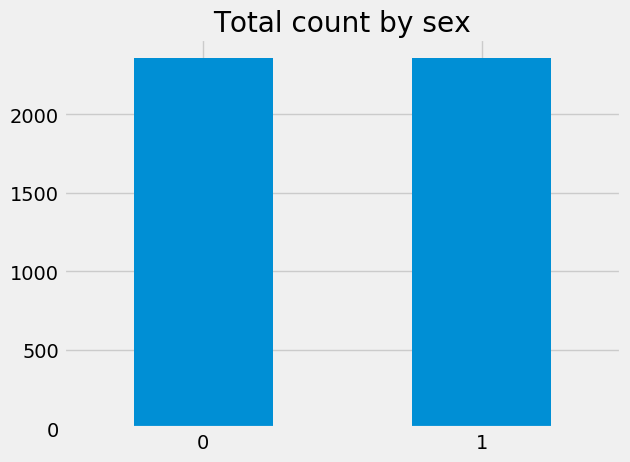

In [47]:
df_sampled['sex'].value_counts().sort_values().plot(kind='bar', 
                                                    title='Total count by sex', 
                                                    rot=0)
plt.show()

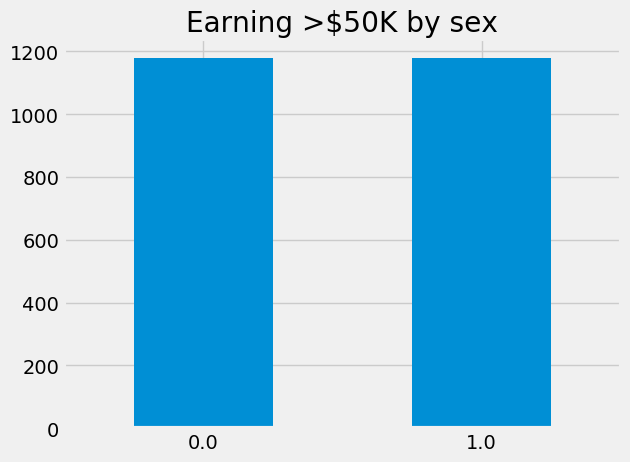

In [48]:
df_sampled['sex'].where(df_sampled['target'] == 1).value_counts().sort_values().plot(
    kind='bar', title='Earning >$50K by sex', rot=0)
plt.show()

In [49]:
df_sampled.to_csv('adult/adult-data-train-sampled.csv', index=False, header=False)
train_sampled_s3_uri = S3Uploader.upload('adult/adult-data-train-sampled.csv', 
                                      f's3://{bucket}/{prefix}/adult-data')

### Rerun the pre-training bias analysis to confirm

In [50]:
exp_datetime_2 = strftime('%Y-%m-%d-%H-%M-%S', gmtime())

# Creating a new trial as we are working on a new dataset
exp_trial_2 = Trial.create(experiment_name=experiment_name, 
                         trial_name=exp_datetime_2)

experiment_config={'ExperimentName': experiment_name,
                   'TrialName': exp_trial_2.trial_name,
                   'TrialComponentDisplayName': 'Pretraining-BiasAnalysis'}

pretraining_bias_report_output_path = f's3://{bucket}/{prefix}/{experiment_name}-{exp_trial_2.trial_name}/clarify-pretraining-bias'

bias_data_config = clarify.DataConfig(
    s3_data_input_path=train_sampled_s3_uri,
    s3_output_path=pretraining_bias_report_output_path,
    label='target',
    headers=df_sampled.columns.tolist(),
    dataset_type='text/csv')

bias_config = clarify.BiasConfig(
    label_values_or_threshold=[1], 
    facet_name=['sex', 'race'], 
    facet_values_or_threshold=[[0], None])

jobname = f'adult-sampled-clarify-pretraining-bias-{exp_datetime_2}'

clarify_processor.run_pre_training_bias(
    data_config=bias_data_config,
    data_bias_config=bias_config,
    methods='all',
    job_name=jobname,
    experiment_config=experiment_config,
    wait=False,
    logs=False)

INFO:sagemaker.clarify:Analysis Config: {'dataset_type': 'text/csv', 'headers': ['target', 'age', 'workclass', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country'], 'label': 'target', 'label_values_or_threshold': [1], 'facet': [{'name_or_index': 'sex', 'value_or_threshold': [0]}, {'name_or_index': 'race'}], 'methods': {'report': {'name': 'report', 'title': 'Analysis Report'}, 'pre_training_bias': {'methods': 'all'}}}
INFO:sagemaker:Creating processing-job with name adult-sampled-clarify-pretraining-bias-2023-02-08-12-31-34



Job Name:  adult-sampled-clarify-pretraining-bias-2023-02-08-12-31-34
Inputs:  [{'InputName': 'dataset', 'AppManaged': False, 'S3Input': {'S3Uri': 's3://sagemaker-studio-075912829265-fl4eu3b4xp5/sagemaker-studio-book/chapter06/adult-data/adult-data-train-sampled.csv', 'LocalPath': '/opt/ml/processing/input/data', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}, {'InputName': 'analysis_config', 'AppManaged': False, 'S3Input': {'S3Uri': 's3://sagemaker-studio-075912829265-fl4eu3b4xp5/sagemaker-studio-book/chapter06/adult-income-clarify-2023-02-08-12-31-34/clarify-pretraining-bias/analysis_config.json', 'LocalPath': '/opt/ml/processing/input/config', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}]
Outputs:  [{'OutputName': 'analysis_result', 'AppManaged': False, 'S3Output': {'S3Uri': 's3://sagemaker-studio-075912829265-fl4eu3b4xp5/sagema

## Training a ML model using XGBoost

In [51]:
exp_datetime_3 = strftime('%Y-%m-%d-%H-%M-%S', gmtime())
jobname = f'adult-xgb-{exp_datetime_3}'

experiment_config={'ExperimentName': experiment_name,
                   'TrialName': exp_trial_2.trial_name,
                   'TrialComponentDisplayName': 'Training'}

image = image_uris.retrieve(region=region, framework='xgboost', version='1.3-1')

train_s3_output = f's3://{bucket}/{prefix}/{experiment_name}-{exp_trial_2.trial_name}/training'

xgb = sagemaker.estimator.Estimator(image,
                                    role,
                                    instance_type='ml.m5.xlarge',
                                    instance_count=1,
                                    output_path=train_s3_output,
                                    enable_sagemaker_metrics=True,
                                    sagemaker_session=sess)
xgb.set_hyperparameters(objective='binary:logistic',
                        eval_metric='error',
                        num_round=50)

train_input = sagemaker.inputs.TrainingInput(s3_data=train_sampled_s3_uri, 
                                             content_type='csv')

val_input = sagemaker.inputs.TrainingInput(s3_data=val_s3_uri, 
                                             content_type='csv')

data_channels={'train': train_input, 'validation': val_input}

xgb.fit(inputs=data_channels, 
        job_name=jobname, 
        experiment_config=experiment_config, 
        wait=True)

INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker:Creating training-job with name: adult-xgb-2023-02-08-12-32-04


2023-02-08 12:32:04 Starting - Starting the training job...
2023-02-08 12:32:28 Starting - Preparing the instances for trainingProfilerReport-1675859524: InProgress
......
2023-02-08 12:33:29 Downloading - Downloading input data...
2023-02-08 12:34:02 Training - Training image download completed. Training in progress...[2023-02-08 12:34:12.864 ip-10-2-83-82.ec2.internal:7 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2023-02-08:12:34:12:INFO] Imported framework sagemaker_xgboost_container.training
[2023-02-08:12:34:12:INFO] Failed to parse hyperparameter eval_metric value error to Json.
Returning the value itself
[2023-02-08:12:34:12:INFO] Failed to parse hyperparameter objective value binary:logistic to Json.
Returning the value itself
[2023-02-08:12:34:12:INFO] No GPUs detected (normal if no gpus installed)
[2023-02-08:12:34:12:INFO] Running XGBoost Sagemaker in algorithm mode
[2023-02-08:12:34:12:INFO] Determined delimiter of CSV input is ','
[2023-02-08:12:34:12:INFO] Dete

In [52]:
model_name = f'adult-xgb-model-{exp_datetime_3}'
model = xgb.create_model(name=model_name)

container_def = model.prepare_container_def()
sess.create_model(model_name, role, container_def)

INFO:sagemaker:Creating model with name: adult-xgb-model-2023-02-08-12-32-04


'adult-xgb-model-2023-02-08-12-32-04'

## Detecting post-training bias

In [53]:
experiment_config={'ExperimentName': experiment_name,
                   'TrialName': exp_trial_2.trial_name,
                   'TrialComponentDisplayName': 'Posttraining-BiasAnalysis'}

posttraining_bias_report_output_path = f's3://{bucket}/{prefix}/{experiment_name}-{exp_trial_2.trial_name}/clarify-posttraining-bias'

bias_data_config = clarify.DataConfig(
    s3_data_input_path=train_sampled_s3_uri,
    s3_output_path=posttraining_bias_report_output_path,
    label='target',
    headers=df_sampled.columns.tolist(),
    dataset_type='text/csv')

bias_config = clarify.BiasConfig(
    label_values_or_threshold=[1], 
    facet_name=['sex', 'race'], 
    facet_values_or_threshold=[[0], None])

In [54]:
model_config = clarify.ModelConfig(
    model_name=model_name,
    instance_type='ml.m5.xlarge',
    instance_count=1,
    accept_type='text/csv',
    content_type='text/csv')

predictions_config = clarify.ModelPredictedLabelConfig(probability_threshold=0.5)

In [55]:
exp_datetime_4 = strftime('%Y-%m-%d-%H-%M-%S', gmtime())
jobname = f'adult-sampled-clarify-posttraining-bias-{exp_datetime_4}'

clarify_processor.run_post_training_bias(
    data_config=bias_data_config,
    data_bias_config=bias_config,
    model_config=model_config,
    model_predicted_label_config=predictions_config,
    methods='all',    
    job_name=jobname,
    experiment_config=experiment_config,
    wait=False,
    logs=False)

INFO:sagemaker.clarify:Analysis Config: {'dataset_type': 'text/csv', 'headers': ['target', 'age', 'workclass', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country'], 'label': 'target', 'label_values_or_threshold': [1], 'facet': [{'name_or_index': 'sex', 'value_or_threshold': [0]}, {'name_or_index': 'race'}], 'methods': {'report': {'name': 'report', 'title': 'Analysis Report'}, 'post_training_bias': {'methods': 'all'}}, 'predictor': {'model_name': 'adult-xgb-model-2023-02-08-12-32-04', 'instance_type': 'ml.m5.xlarge', 'initial_instance_count': 1, 'accept_type': 'text/csv', 'content_type': 'text/csv'}, 'probability_threshold': 0.5}
INFO:sagemaker:Creating processing-job with name adult-sampled-clarify-posttraining-bias-2023-02-08-12-36-20



Job Name:  adult-sampled-clarify-posttraining-bias-2023-02-08-12-36-20
Inputs:  [{'InputName': 'dataset', 'AppManaged': False, 'S3Input': {'S3Uri': 's3://sagemaker-studio-075912829265-fl4eu3b4xp5/sagemaker-studio-book/chapter06/adult-data/adult-data-train-sampled.csv', 'LocalPath': '/opt/ml/processing/input/data', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}, {'InputName': 'analysis_config', 'AppManaged': False, 'S3Input': {'S3Uri': 's3://sagemaker-studio-075912829265-fl4eu3b4xp5/sagemaker-studio-book/chapter06/adult-income-clarify-2023-02-08-12-31-34/clarify-posttraining-bias/analysis_config.json', 'LocalPath': '/opt/ml/processing/input/config', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}]
Outputs:  [{'OutputName': 'analysis_result', 'AppManaged': False, 'S3Output': {'S3Uri': 's3://sagemaker-studio-075912829265-fl4eu3b4xp5/sage

## Explaining ML models using SHAP values

In [56]:
experiment_config={'ExperimentName': experiment_name,
                   'TrialName': exp_trial_2.trial_name,
                   'TrialComponentDisplayName': 'Posttraining-SHAP'}

explainability_output_path = f's3://{bucket}/{prefix}/{experiment_name}-{exp_trial_2.trial_name}/clarify-explainability'

explainability_data_config = clarify.DataConfig(
    s3_data_input_path=train_sampled_s3_uri,
    s3_output_path=explainability_output_path,
    label='target',
    headers=df_sampled.columns.tolist(),
    dataset_type='text/csv')

model_config = clarify.ModelConfig(
    model_name=model_name,
    instance_type='ml.m5.xlarge',
    instance_count=1,
    accept_type='text/csv',
    content_type='text/csv')

baseline = df_sampled.query('target == 1').mode().iloc[0, 1:].astype(int).tolist()
shap_config = clarify.SHAPConfig(
    baseline=[baseline],
    num_samples=15,
    agg_method='mean_abs')

In [57]:
exp_datetime_5 = strftime('%Y-%m-%d-%H-%M-%S', gmtime())
jobname = f'adult-sampled-clarify-posttraining-shap-{exp_datetime_5}'

clarify_processor.run_explainability(
    data_config=explainability_data_config,
    model_config=model_config,
    explainability_config=shap_config,
    job_name=jobname,
    experiment_config=experiment_config)

INFO:sagemaker.clarify:Analysis Config: {'dataset_type': 'text/csv', 'headers': ['target', 'age', 'workclass', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country'], 'label': 'target', 'predictor': {'model_name': 'adult-xgb-model-2023-02-08-12-32-04', 'instance_type': 'ml.m5.xlarge', 'initial_instance_count': 1, 'accept_type': 'text/csv', 'content_type': 'text/csv'}, 'methods': {'report': {'name': 'report', 'title': 'Analysis Report'}, 'shap': {'use_logit': False, 'save_local_shap_values': True, 'baseline': [[43, 4, 101345, 13, 2, 10, 0, 4, 0, 0, 0, 40, 39]], 'num_samples': 15, 'agg_method': 'mean_abs'}}}
INFO:sagemaker:Creating processing-job with name adult-sampled-clarify-posttraining-shap-2023-02-08-12-36-36



Job Name:  adult-sampled-clarify-posttraining-shap-2023-02-08-12-36-36
Inputs:  [{'InputName': 'dataset', 'AppManaged': False, 'S3Input': {'S3Uri': 's3://sagemaker-studio-075912829265-fl4eu3b4xp5/sagemaker-studio-book/chapter06/adult-data/adult-data-train-sampled.csv', 'LocalPath': '/opt/ml/processing/input/data', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}, {'InputName': 'analysis_config', 'AppManaged': False, 'S3Input': {'S3Uri': 's3://sagemaker-studio-075912829265-fl4eu3b4xp5/sagemaker-studio-book/chapter06/adult-income-clarify-2023-02-08-12-31-34/clarify-explainability/analysis_config.json', 'LocalPath': '/opt/ml/processing/input/config', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}]
Outputs:  [{'OutputName': 'analysis_result', 'AppManaged': False, 'S3Output': {'S3Uri': 's3://sagemaker-studio-075912829265-fl4eu3b4xp5/sagemak

Example number: 500
with model prediction: <=50K

Feature values: 
       target  age  workclass  fnlwgt  education-num  marital-status  \
12454       0   42          4   30824             14               0   

       occupation  relationship  race  sex  capital-gain  capital-loss  \
12454          10             1     4    0          2354             0   

       hours-per-week  native-country  
12454              16              39  


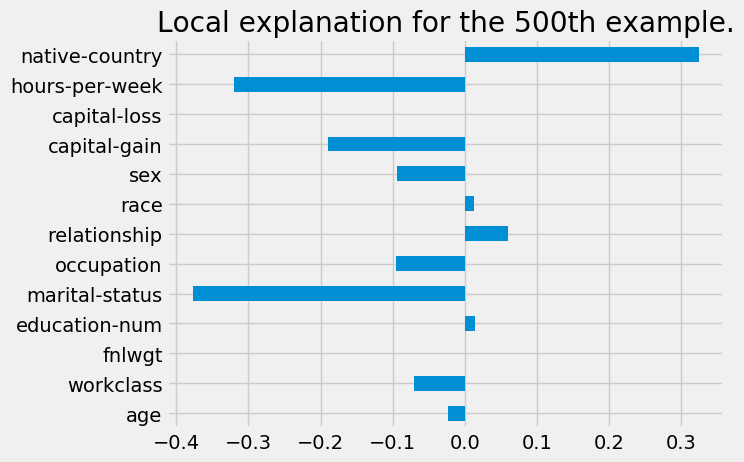

In [58]:
S3Downloader.download(f'{explainability_output_path}/explanations_shap/out.csv', 
                      './',
                      sagemaker_session=sess)
local_explanations_out = pd.read_csv('out.csv')
feature_names = [str.replace(c, '_label0', '') 
                 for c in local_explanations_out.columns.to_series()]
local_explanations_out.columns = feature_names

selected_example = 500
sample_prediction='>50K' if sum(local_explanations_out.iloc[selected_example]) > 0 else '<=50K'
print(f'Example number: {selected_example}')
print(f'with model prediction: {sample_prediction}')
print()
print(f'Feature values: \n{df_sampled.iloc[selected_example].to_frame().T}')

local_explanations_out.iloc[selected_example].plot(
    kind='barh', 
    title=f'Local explanation for the {selected_example}th example.', 
    rot=0)
plt.show()